In [215]:
import numpy as np
import pandas as pd
import tokenizers
from tqdm import tqdm
from tokenizers import pre_tokenizers
from torch.utils.data import Dataset,DataLoader
import tokenizers.trainers
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer
import json
import pyperclip
import re
from torch.distributions import Categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import random as rd
from seaborn import heatmap
import torch.nn as nn
import torch

### Corona dataset

In [ ]:
main_data = pd.read_csv('/home/luchian/all_data/uni_data/corona.csv', usecols=['OriginalTweet','Sentiment'])
main_data

,OriginalTweet,Sentiment
0,"Guess?, Inc. Provides COVID-19 Business Update...",Positive
1,So much panic-bought food fresh food will neve...,Positive
2,Instead of giving financial aid that is close ...,Positive
3,WAIT A DAMN MINUTE\r\r\n\r\r\nso Amazon worker...,Positive
4,Pig prices were up this week at 163 39p kg amp...,Extremely Positive
...,...,...
9995,???https://t.co/Ljh5cmUkMPÂ via @amazon ???ht...,Extremely Positive
9996,P Stuck inside Our pals at have slashed prices...,Positive
9997,If you think you may experience financial hard...,Positive
9998,"No toilet paper I can handle, no pasta, ok...b...",Extremely Negative


In [7]:
label_encoder = LabelEncoder().fit(main_data['Sentiment'])
label_encoder.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

In [8]:
main_data['Sentiment'] = label_encoder.transform(main_data['Sentiment'])

In [9]:
main_data.head(5)

,OriginalTweet,Sentiment
0,"Guess?, Inc. Provides COVID-19 Business Update...",4
1,So much panic-bought food fresh food will neve...,4
2,Instead of giving financial aid that is close ...,4
3,WAIT A DAMN MINUTE\r\r\n\r\r\nso Amazon worker...,4
4,Pig prices were up this week at 163 39p kg amp...,1


In [13]:
Train,Test = train_test_split(main_data,train_size = 0.85,stratify = main_data['Sentiment'])

In [14]:
Train.head(5)

,OriginalTweet,Sentiment
5928,@mccrory @Costco MyPOV: pretty much. well it's...,1
5959,If you want to learn about the impact of COVID...,4
2323,"I'm on New impressionz live, clapping for can ...",3
146,The US Attorney's Office has released an offic...,0
2920,Be aware that Scamming activity increases duri...,4


In [15]:
Test.head(5)

,OriginalTweet,Sentiment
7447,The US is asking other countries for everythin...,4
7825,Really @Bell @Bell_Support people are losing j...,4
9057,"moonbeamwishes Hey, Megan! We will work to kee...",4
9359,Maine retail group chief worried about crisis-...,2
9775,"According to a survey by @Path2PurchaseIQ, sho...",3


In [16]:
def proc_text(text):
    lowered = text.lower()
    tokenized = ' '.join(re.findall(r"[A-z0-9]+[A-z0-9]",lowered))
    return tokenized

In [17]:
def train_tokens():
    for row in range(len(Train.iloc[:,0])):
        processed = proc_text(Train.iloc[row,0])
        yield processed

In [18]:
tokenizer = Tokenizer(model = tokenizers.models.WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000,special_tokens = ['<pad>','<unk>'])
tokenizer.enable_padding(direction='right',pad_id = 0,pad_token='<pad>')
tokenizer.train_from_iterator(train_tokens(),trainer=tok_trainer)
tokenizer.save('./tok_voc')

In [19]:
class TextDataset(Dataset):
    def __init__(self,texts,tok_path,processing,max_len):
        self.texts = texts
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_file = tok_path)
        self.processing = processing
        self.max_length = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.texts.iloc[indx,0]),torch.tensor(self.texts.iloc[indx,1].item())
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        return tokenized_text.squeeze(dim = 0),label

In [20]:
TrainDataset = TextDataset(texts = Train,
                           tok_path='./tok_voc',
                           processing=proc_text,
                           max_len = 70)

In [21]:
TestDataset = TextDataset(texts = Test,
                           tok_path='./tok_voc',
                           processing=proc_text,
                           max_len = 70)

In [214]:
class ClassificationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_size,bi = True,bf = True):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.gru = nn.GRU(input_size = embed_dim,hidden_size = hidden_size,bidirectional = bi,batch_first=bf,num_layers=2,dropout=0.5)
        self.linear = nn.Linear(600,5)

    def forward(self,x):
        y = self.embed(x)
        _,y = self.gru(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [215]:
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 300
my_model = ClassificationModel(vocab_size=vocab_size,
                               embed_dim = embedding_dim,
                               hidden_size=150)

In [218]:
def train_model(model,train_loader,epoch,main_optim,main_loss,print_every = 1):
    try:
        train_losses = []
        for ep in range(epoch):
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader,desc=f'Going through the loader on epoch #{ep+1}'):
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            if ep%print_every == 0:
                print(f'Epoch #{ep+1} | Train loss: {train_losses[-1]}',end = '\n\n')
        return train_losses
    except KeyboardInterrupt:
        return train_losses

In [219]:
weights = compute_class_weight(class_weight='balanced',y = Train['Sentiment'],classes=np.array([_ for _ in range(5)]))
weights = torch.from_numpy(weights).to(dtype = torch.float32)
weights

tensor([1.4965, 1.2583, 0.8240, 1.0732, 0.7185])

In [220]:
#train
epoch = 25
batch_size = 54
lr = 0.0005
loader = DataLoader(dataset = TrainDataset,shuffle = True,batch_size = batch_size)
optimizer = torch.optim.Adam(my_model.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',weight = weights,label_smoothing=0.001)

In [222]:
results = train_model(model = my_model,
                      train_loader = loader,
                      epoch = epoch,
                      main_optim = optimizer,
                      main_loss = criterion
                      )

Going through the loader on epoch #1: 100%|██████████| 158/158 [00:28<00:00,  5.57it/s]


Epoch #1 | Train loss: 1.55646



Going through the loader on epoch #2: 100%|██████████| 158/158 [00:27<00:00,  5.74it/s]


Epoch #2 | Train loss: 1.28497



Going through the loader on epoch #3: 100%|██████████| 158/158 [00:28<00:00,  5.62it/s]


Epoch #3 | Train loss: 1.04236



Going through the loader on epoch #4: 100%|██████████| 158/158 [00:27<00:00,  5.83it/s]


Epoch #4 | Train loss: 0.81879



Going through the loader on epoch #5: 100%|██████████| 158/158 [00:26<00:00,  5.87it/s]


Epoch #5 | Train loss: 0.62574



Going through the loader on epoch #6: 100%|██████████| 158/158 [00:26<00:00,  5.88it/s]


Epoch #6 | Train loss: 0.45525



Going through the loader on epoch #7: 100%|██████████| 158/158 [00:26<00:00,  5.86it/s]


Epoch #7 | Train loss: 0.31571



Going through the loader on epoch #8: 100%|██████████| 158/158 [00:26<00:00,  5.88it/s]


Epoch #8 | Train loss: 0.22203



Going through the loader on epoch #9: 100%|██████████| 158/158 [00:26<00:00,  5.86it/s]


Epoch #9 | Train loss: 0.14911



Going through the loader on epoch #10: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #10 | Train loss: 0.12094



Going through the loader on epoch #11: 100%|██████████| 158/158 [00:27<00:00,  5.80it/s]


Epoch #11 | Train loss: 0.09225



Going through the loader on epoch #12: 100%|██████████| 158/158 [00:27<00:00,  5.79it/s]


Epoch #12 | Train loss: 0.07568



Going through the loader on epoch #13: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #13 | Train loss: 0.06341



Going through the loader on epoch #14: 100%|██████████| 158/158 [00:27<00:00,  5.74it/s]


Epoch #14 | Train loss: 0.04744



Going through the loader on epoch #15: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #15 | Train loss: 0.05378



Going through the loader on epoch #16: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #16 | Train loss: 0.04551



Going through the loader on epoch #17: 100%|██████████| 158/158 [00:27<00:00,  5.76it/s]


Epoch #17 | Train loss: 0.03366



Going through the loader on epoch #18: 100%|██████████| 158/158 [00:27<00:00,  5.73it/s]


Epoch #18 | Train loss: 0.03523



Going through the loader on epoch #19: 100%|██████████| 158/158 [00:27<00:00,  5.77it/s]


Epoch #19 | Train loss: 0.03699



Going through the loader on epoch #20: 100%|██████████| 158/158 [00:28<00:00,  5.57it/s]


Epoch #20 | Train loss: 0.03395



Going through the loader on epoch #21:  16%|█▋        | 26/158 [00:04<00:24,  5.36it/s]


In [223]:
@torch.no_grad()
def get_preds(model,Val):
    model.eval()
    the_loader = DataLoader(dataset = Val, shuffle = False, batch_size = 1)
    y_true_list = []
    y_pred_list = []
    for X,y in the_loader:
        probs = model(X).softmax(dim = 1)
        distribution = Categorical(probs)
        y_pred = distribution.sample()
        y_true_list.append(y.item())
        y_pred_list.append(y_pred.item())
    return np.array(y_true_list),np.array(y_pred_list)

In [ ]:
y_true, y_pred = get_preds(my_model,TestDataset)

In [225]:
report = classification_report(y_true = y_true,y_pred = y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.60      0.55       201
           1       0.62      0.54      0.58       238
           2       0.40      0.47      0.43       364
           3       0.53      0.52      0.53       280
           4       0.50      0.43      0.46       417

    accuracy                           0.49      1500
   macro avg       0.51      0.51      0.51      1500
weighted avg       0.50      0.49      0.50      1500



<Axes: >

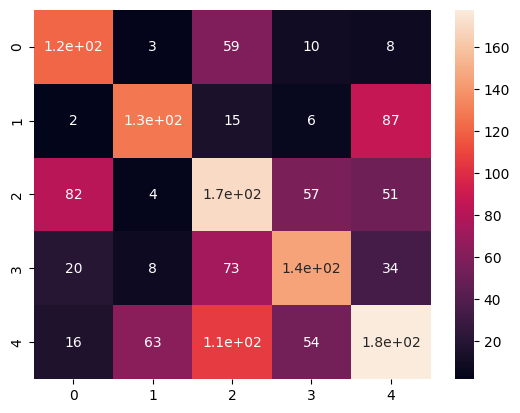

In [226]:
conf_matrix = confusion_matrix(y_true = y_true,y_pred = y_pred)
heatmap(conf_matrix,annot = True)

In [ ]:
label_encoder.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype=object)

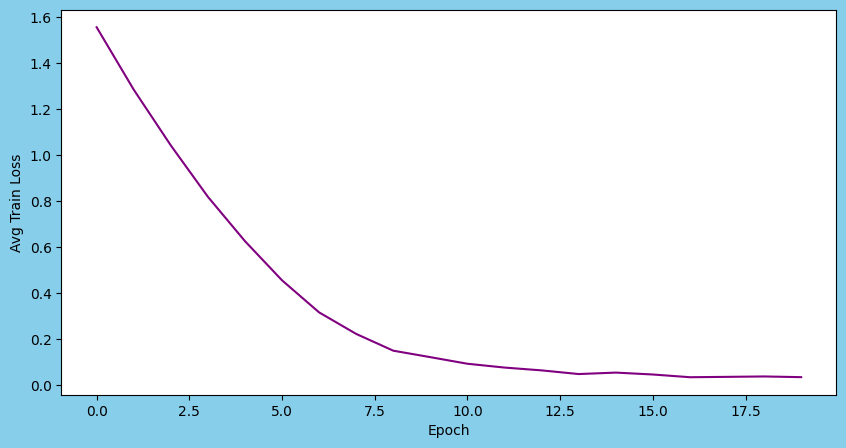

In [229]:
import matplotlib.pyplot as plt
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_xlabel('Epoch')
some_ax.set_ylabel('Avg Train Loss')
some_ax.plot(results,c = 'purple')

In [266]:
def model_inf(text):
    my_model.eval()
    tokenizer = TrainDataset.tokenizer
    processing = TrainDataset.processing
    main_text = processing(text)
    tokens = tokenizer(
            main_text,
            max_length = TrainDataset.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True)['input_ids']
    y_pred = my_model(tokens).softmax(dim = 1).argmax(dim = 1).item()
    return label_encoder.classes_[y_pred]

In [269]:
model_inf('Thex exam is pretty well managed. I like it, organisers did a pretty good job')

'Extremely Positive'

In [270]:
model_inf('but I hate everything about this stupid exam')

'Negative'

### news dataset

In [13]:
news_data = pd.read_csv('/home/luchian/all_data/uni_data/NLP_datasets/news.csv', usecols = ['Class Index','Title'])
print(news_data.info(),end = '\n\n')
news_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  10000 non-null  int64 
 1   Title        10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None



,Class Index,Title
0,2,Iowa Expecting Capital One Invitation (AP)
1,1,106 mainland enterprises listed outside mainla...
2,4,Internet crackdown leads to over 100 arrests
3,2,Williams vs Klitschko: When A Comet Crashes In...
4,4,Dell Gets \$700M Deal From Royal Philips


In [107]:
label_encoder = LabelEncoder().fit(news_data['Class Index'])
label_encoder

LabelEncoder()

In [109]:
label_encoder.classes_

array([1, 2, 3, 4])

In [110]:
news_data['Class Index'] = label_encoder.transform(news_data['Class Index'])

In [111]:
news_data.head(5)

,Class Index,Title
0,1,Iowa Expecting Capital One Invitation (AP)
1,0,106 mainland enterprises listed outside mainla...
2,3,Internet crackdown leads to over 100 arrests
3,1,Williams vs Klitschko: When A Comet Crashes In...
4,3,Dell Gets \$700M Deal From Royal Philips


In [300]:
Train_news,Test_news = train_test_split(news_data,train_size = 0.9,stratify=news_data['Class Index'])
print(len(Train_news))
print(len(Test_news))

9000
1000


In [33]:
sample_text = Train_news.iloc[rd.randint(1,9000),1]
sample_text

'NFL Wrap: McNabb Leads Eagles to Fourth East Title'

In [ ]:
def proc_text(text):
    """simple processing of a text"""
    lowered = text.lower()
    tokenized = ' '.join(re.findall(r"[A-z0-9]+[A-z0-9]",lowered))
    return tokenized

In [270]:
proc_text(sample_text)

'nfl wrap mcnabb leads eagles to fourth east title'

In [ ]:
def train_tokens():
    """creates a training generator for tokenizing"""
    for row in range(len(Train_news.iloc[:,1])):
        processed = proc_text(Train_news.iloc[row,1]) 
        yield processed

In [112]:
def tokenizer_to_path(gen):
    """creates a doc with voc for further use with FastTokenizer from transformers"""
    tokenizer = Tokenizer(model = tokenizers.models.WordLevel(unk_token='<unk>'))
    tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
    tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000,special_tokens = ['<pad>','<unk>'])
    tokenizer.enable_padding(direction='right',pad_id = 0,pad_token='<pad>')
    tokenizer.train_from_iterator(gen,trainer=tok_trainer)
    return tokenizer

In [115]:
tok = tokenizer_to_path(train_tokens())
print(type(tok))

<class 'tokenizers.Tokenizer'>


In [277]:
tok.get_vocab_size()

11201

In [118]:
class TextDataset(Dataset):
    def __init__(self,texts,tok_obj,processing,max_len):
        self.texts = texts
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_object = tok_obj)
        self.processing = processing
        self.max_length = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.texts.iloc[indx,1]),torch.tensor(self.texts.iloc[indx,0].item())
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        return tokenized_text.squeeze(dim = 0),label

In [309]:
News_torch_train = TextDataset(Train_news,tok,proc_text,12)
News_torch_test = TextDataset(Test_news,tok,proc_text,12)

In [310]:
class ClassificationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_size,bi = True,bf = True):
        super().__init__() #initialization of super class
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.gru = nn.GRU(input_size = embed_dim,hidden_size = hidden_size,bidirectional = bi,batch_first=bf,num_layers=2,dropout=0.5)
        self.linear = nn.Linear(600,4)

    def forward(self,x):
        y = self.embed(x)
        _,y = self.gru(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [311]:
def train_model(model,train_loader,epoch,main_optim,main_loss,print_every = 1):
    try:
        train_losses = []
        for ep in range(epoch):
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader,desc=f'Going through the loader on epoch #{ep+1}'):
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            if ep%print_every == 0:
                print(f'Epoch #{ep+1} | Train loss: {train_losses[-1]}',end = '\n\n')
        return train_losses
    except KeyboardInterrupt:
        return train_losses

In [312]:
weights = compute_class_weight(class_weight='balanced',y = Train_news['Class Index'],classes=np.array([_ for _ in range(4)]))
weights = torch.from_numpy(weights).to(dtype = torch.float32)
weights

tensor([0.9707, 1.0158, 1.0103, 1.0045])

In [313]:
vocab_size = tok.get_vocab_size()
embed_dim = 300
hidden_size = 150

In [314]:
my_mod = ClassificationModel(vocab_size,embed_dim,hidden_size)
my_mod

ClassificationModel(
  (embed): Embedding(11201, 300, padding_idx=0)
  (gru): GRU(300, 150, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=600, out_features=4, bias=True)
)

In [315]:
#train
epoch = 20
batch_size = 46
lr = 0.0005
loader = DataLoader(dataset = News_torch_train,shuffle = True,batch_size = batch_size)
optimizer = torch.optim.Adam(my_mod.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',weight = weights,label_smoothing=0.0001)

In [316]:
results = train_model(model = my_mod,
                      train_loader = loader,
                      epoch = epoch,
                      main_optim = optimizer,
                      main_loss = criterion
                      )

Going through the loader on epoch #1: 100%|██████████| 196/196 [00:10<00:00, 18.43it/s]


Epoch #1 | Train loss: 1.11327



Going through the loader on epoch #2: 100%|██████████| 196/196 [00:09<00:00, 21.62it/s]


Epoch #2 | Train loss: 0.64781



Going through the loader on epoch #3: 100%|██████████| 196/196 [00:08<00:00, 22.67it/s]


Epoch #3 | Train loss: 0.3971



Going through the loader on epoch #4: 100%|██████████| 196/196 [00:08<00:00, 24.34it/s]


Epoch #4 | Train loss: 0.21929



Going through the loader on epoch #5: 100%|██████████| 196/196 [00:08<00:00, 23.24it/s]


Epoch #5 | Train loss: 0.11343



Going through the loader on epoch #6: 100%|██████████| 196/196 [00:08<00:00, 23.68it/s]


Epoch #6 | Train loss: 0.06902



Going through the loader on epoch #7: 100%|██████████| 196/196 [00:08<00:00, 23.16it/s]


Epoch #7 | Train loss: 0.04947



Going through the loader on epoch #8: 100%|██████████| 196/196 [00:08<00:00, 24.16it/s]


Epoch #8 | Train loss: 0.04243



Going through the loader on epoch #9: 100%|██████████| 196/196 [00:09<00:00, 21.09it/s]


Epoch #9 | Train loss: 0.0388



Going through the loader on epoch #10: 100%|██████████| 196/196 [00:09<00:00, 20.66it/s]


Epoch #10 | Train loss: 0.02371



Going through the loader on epoch #11: 100%|██████████| 196/196 [00:09<00:00, 20.51it/s]


Epoch #11 | Train loss: 0.02463



Going through the loader on epoch #12: 100%|██████████| 196/196 [00:09<00:00, 21.74it/s]


Epoch #12 | Train loss: 0.02437



Going through the loader on epoch #13: 100%|██████████| 196/196 [00:08<00:00, 24.33it/s]


Epoch #13 | Train loss: 0.01797



Going through the loader on epoch #14: 100%|██████████| 196/196 [00:08<00:00, 21.78it/s]


Epoch #14 | Train loss: 0.01704



Going through the loader on epoch #15: 100%|██████████| 196/196 [00:09<00:00, 21.59it/s]


Epoch #15 | Train loss: 0.01753



Going through the loader on epoch #16: 100%|██████████| 196/196 [00:08<00:00, 22.26it/s]


Epoch #16 | Train loss: 0.01538



Going through the loader on epoch #17: 100%|██████████| 196/196 [00:09<00:00, 20.30it/s]


Epoch #17 | Train loss: 0.01413



Going through the loader on epoch #18: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s]


Epoch #18 | Train loss: 0.01561



Going through the loader on epoch #19: 100%|██████████| 196/196 [00:09<00:00, 21.44it/s]


Epoch #19 | Train loss: 0.01359



Going through the loader on epoch #20: 100%|██████████| 196/196 [00:08<00:00, 24.33it/s]

Epoch #20 | Train loss: 0.00985



In [317]:
@torch.no_grad()
def get_preds(model,Val):
    model.eval()
    the_loader = DataLoader(dataset = Val, shuffle = False, batch_size = 1)
    y_true_list = []
    y_pred_list = []
    for X,y in the_loader:
        probs = model(X).softmax(dim = 1)
        distribution = Categorical(probs)
        y_pred = distribution.sample()
        y_true_list.append(y.item())
        y_pred_list.append(y_pred.item())
    return np.array(y_true_list),np.array(y_pred_list)

In [318]:
y_true, y_pred = get_preds(my_mod,News_torch_test)

In [319]:
report = classification_report(y_true = y_true,y_pred = y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       257
           1       0.75      0.68      0.71       246
           2       0.65      0.65      0.65       248
           3       0.67      0.76      0.71       249

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



<Axes: >

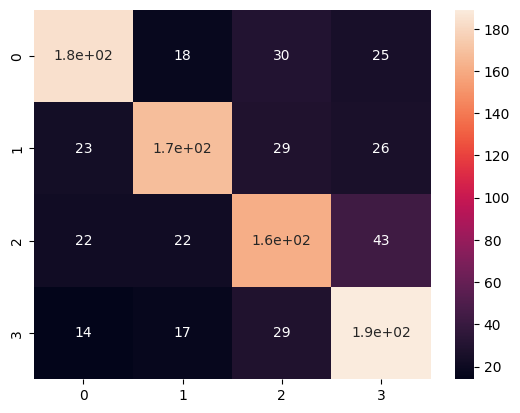

In [320]:
conf_matrix = confusion_matrix(y_true = y_true,y_pred = y_pred)
heatmap(conf_matrix,annot = True)

In [321]:
label_encoder.classes_

array([1, 2, 3, 4])

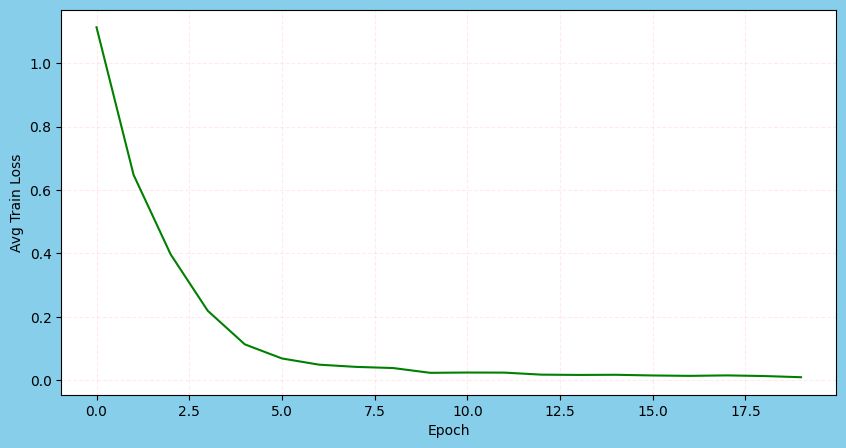

In [323]:
import matplotlib.pyplot as plt
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_xlabel('Epoch')
some_ax.set_ylabel('Avg Train Loss')
some_ax.grid(linestyle = '--',c = 'pink',alpha = 0.32)
some_ax.plot(results,c = 'green')

In [344]:
class ModelInf(object):
    def __init__(self,model,TrainSet):
        self.model = model
        self.dataset = TrainSet
    
    def __call__(self,text):
        self.model.eval()
        main_text = self.dataset.processing(text)
        tokens = self.dataset.tokenizer(
                main_text,
                max_length = self.dataset.max_length,
                padding = 'max_length',
                return_tensors='pt',
                truncation=True)['input_ids']
        y_pred = self.model(tokens).softmax(dim = 1).argmax(dim = 1).item()
        return label_encoder.classes_[y_pred].item()

In [356]:
inf = ModelInf(my_mod,News_torch_train)

In [371]:
t1,t2 = Test_news.iloc[rd.randint(0,999),1],Test_news.iloc[rd.randint(0,999),1]
print(f'Text: {t1}\nprediction: {inf(t1)}',end = '\n\n')
print(f'Text: {t2}\nprediction: {inf(t2)}')

Text: Astros Beat Rockies to Win NL Playoff Spot
prediction: 2

Text: Chilean judge halts his questioning of ailing ex-dictator
prediction: 1


### tweet_cat dataset

In [558]:
tweet_cat_dataset = pd.read_csv('~/Downloads/tweet_cat.csv')
tweet_cat_dataset.head(5)

,text,type
0,@ACNI2012 @TheToka920 Never knew having 1 or 2...,sports
1,"MYCA Magical Moments:\n\nSeptember, 2011: Sham...",sports
2,The current state of last year's @BBL finalist...,sports
3,@HOLLYJISOO Why did you bring a cricket...,sports
4,Babar Azam only Pakistani included in the ICC ...,sports


In [559]:
label_enc = LabelEncoder()
label_enc

LabelEncoder()

In [560]:
tweet_cat_dataset['type'] = label_enc.fit_transform(tweet_cat_dataset['type'])

In [562]:
label_enc.classes_

array(['entertainment', 'medical', 'politics', 'sports'], dtype=object)

In [8]:
tweet_cat_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1162 non-null   object
 1   type    1162 non-null   object
dtypes: object(2)
memory usage: 18.3+ KB


In [11]:
tweet_cat_dataset['type'].unique()

array(['sports', 'entertainment', 'medical', 'politics'], dtype=object)

In [316]:
Train, TestVal = train_test_split(tweet_cat_dataset, stratify = tweet_cat_dataset['type'],train_size = 0.8)
print(len(Train))
print(len(TestVal))

929
233


In [317]:
Test, Val = train_test_split(TestVal, stratify = TestVal['type'], train_size = 0.8)
print(len(Test))
print(len(Val))

186
47


In [25]:
def proc_text(text):
    """simple processing of a text"""
    lowered = text.lower()
    tokenized = ' '.join(re.findall(r"[A-z0-9]+[A-z0-9]",lowered))
    return tokenized

In [30]:
def train_tokens(main_train_dataset):
    for row in range(len(main_train_dataset.iloc[:,0])):
        processed = proc_text(main_train_dataset.iloc[row,0])
        yield processed

In [61]:
tokenizer = Tokenizer(model = tokenizers.models.WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000, special_tokens = ['<pad>','<unk>'])
tokenizer.enable_padding(direction='right', pad_id = 0, pad_token='<pad>')
tokenizer.train_from_iterator(train_tokens(Train), trainer=tok_trainer)
tokenizer.save('./tok_voc')

In [308]:
class TextDataset(Dataset):
    def __init__(self,texts,tok_obj,processing,max_len):
        self.texts = texts
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_object = tok_obj)
        self.processing = processing
        self.max_length = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.texts.iloc[indx,0]),torch.tensor(self.texts.iloc[indx,1].item())
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        return tokenized_text.squeeze(dim = 0),label

In [309]:
main_dataset = TextDataset(texts = Train,
                           tok_obj = tokenizer,
                           processing = proc_text,
                           max_len = 30)
main_dataset

In [318]:
cat_torch_train = TextDataset(Train, tokenizer, proc_text, 30)
cat_torch_test = TextDataset(Test, tokenizer, proc_text, 30)
cat_torch_val = TextDataset(Val, tokenizer, proc_text, 30)

In [319]:
print(len(cat_torch_train))
print(len(cat_torch_test))
print(len(cat_torch_val))

929
186
47


In [192]:
class ClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, bi = True, bf = True):
        super().__init__() #initialization of super class
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.gru = nn.GRU(input_size = embed_dim, hidden_size = hidden_size, bidirectional = bi, batch_first=bf, num_layers=2, dropout=0.5)
        self.linear = nn.Linear(600,4)

    def forward(self,x):
        y = self.embed(x)
        _,y = self.gru(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [322]:
cat_torch_test.tokenizer.vocab_size

5819

In [ ]:
def train_model(model,
                train_loader,
                epoch,
                main_optim,
                main_loss,
                patience = 3,
                print_every = 1):
    try:
        train_losses = []
        val_metric = []
        while True:
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader, desc=f'Going through the loader'):
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            y_true_val, y_pred_val = get_preds(model, cat_torch_val)
            val_metric.append(f1_score(y_true_val,y_pred_val,average = 'macro'))
            if len(val_metric) <= patience:
                pass
            else:
                checking_val = val_metric[-patience:]
                count = 0
                #cheking whether we should stop
                for ind in range(len(checking_val)-1):
                    if checking_val[ind+1] <= checking_val[ind]:
                        count += 1
                #breaking if we go down
                if count == len(checking_val)-1:
                    print('Stop training due to patience')
                    break
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            print(f'Train loss: {train_losses[-1]}')
            print(f'Val metric: {val_metric[-1]}',end = '\n\n')
        return train_losses, val_metric
    except KeyboardInterrupt:
        return train_losses, val_metric

In [402]:
my_model = ClassificationModel(cat_torch_test.tokenizer.vocab_size, embed_dim=150, hidden_size=150)
my_model

ClassificationModel(
  (embed): Embedding(5819, 150, padding_idx=0)
  (gru): GRU(150, 150, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=600, out_features=4, bias=True)
)

In [403]:
weights = compute_class_weight(class_weight='balanced', y = lebel_enc.fit_transform(Train['type']), classes = np.array([_ for _ in range(4)]))
weights = torch.from_numpy(weights).to(dtype = torch.float32)
weights

tensor([1.1166, 0.9718, 0.8415, 1.1274])

In [404]:
epoch = 20
batch_size = 46
lr = 0.0005
loader = DataLoader(dataset = cat_torch_train, shuffle = True, batch_size = batch_size)
optimizer = torch.optim.Adam(my_model.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',weight = weights,label_smoothing=0.0001)

In [406]:
train_model(
    model = my_model,
    train_loader = loader,
    epoch = epoch,
    main_optim = optimizer,
    main_loss = criterion,
    print_every = 1,
    patience=2
)

Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 13.56it/s]


Train loss: 1.12555
Val metric: 0.25916666666666666



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 15.10it/s]


Train loss: 0.76483
Val metric: 0.5599865047233469



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


Train loss: 0.49052
Val metric: 0.6091880341880342



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 13.56it/s]


Train loss: 0.34126
Val metric: 0.69408656477622



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 15.04it/s]


Train loss: 0.20872
Val metric: 0.744047619047619



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 14.60it/s]


Train loss: 0.13264
Val metric: 0.8102380952380952



Going through the loader: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s]


Stop training due to patience


[1.12555, 0.76483, 0.49052, 0.34126, 0.20872, 0.13264]

In [337]:
@torch.no_grad()
def get_preds(model, Val):
    model.eval()
    the_loader = DataLoader(dataset = Val, shuffle = False, batch_size = 1)
    y_true_list = []
    y_pred_list = []
    for X,y in the_loader:
        probs = model(X).softmax(dim = 1)
        distribution = Categorical(probs)
        y_pred = distribution.sample()
        y_true_list.append(y.item())
        y_pred_list.append(y_pred.item())
    return np.array(y_true_list),np.array(y_pred_list)

In [412]:
y_true, y_pred = get_preds(my_model,cat_torch_test)
print(y_true.shape)
print(y_pred.shape)

(186,)
(186,)


In [413]:
f1_score(y_true,y_pred,average = 'macro')

0.6988348809000983

In [580]:
def model_inf(text,TrainDataset,label_encoder):
    my_model.eval()
    tokenizer = TrainDataset.tokenizer
    processing = TrainDataset.processing
    main_text = processing(text)
    tokens = tokenizer(
            main_text,
            max_length = TrainDataset.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True)['input_ids']
    y_pred = my_model(tokens).softmax(dim = 1).argmax(dim = 1).item()
    return label_encoder.inverse_transform([y_pred]).item()

In [591]:
sample = Test.iloc[rd.randint(1,100),0]
print(sample)

@mrose1965 I cannot serve an overhead tennis lob.


In [592]:
model_inf(sample,cat_torch_train,label_enc)

'sports'

### quotes dataset

In [3]:
with open('/home/luchian/Downloads/quotes.json','r',encoding = 'utf-8') as main_file:
    quotes_data = json.load(main_file)

In [8]:
print(type(quotes_data))
len(quotes_data)

<class 'list'>


48391

In [9]:
one_item = quotes_data[0]
print(type(one_item))

<class 'dict'>


In [15]:
quotes_data[:5]

[{'Quote': "Don't cry because it's over, smile because it happened.",
  'Author': 'Dr. Seuss',
  'Tags': ['attributed-no-source',
   'cry',
   'crying',
   'experience',
   'happiness',
   'joy',
   'life',
   'misattributed-dr-seuss',
   'optimism',
   'sadness',
   'smile',
   'smiling '],
  'Popularity': 0.15566615566615566,
  'Category': 'life'},
 {'Quote': "Don't cry because it's over, smile because it happened.",
  'Author': 'Dr. Seuss',
  'Tags': ['attributed-no-source',
   'cry',
   'crying',
   'experience',
   'happiness',
   'joy',
   'life',
   'misattributed-dr-seuss',
   'optimism',
   'sadness',
   'smile',
   'smiling '],
  'Popularity': 0.15566615566615566,
  'Category': 'happiness'},
 {'Quote': "I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.",
  'Author': 'Marilyn Monroe',
  'Tags': ['attributed-no-source',
   'bes

In [23]:
main_set = [(the_dict['Quote'],the_dict['Category']) for the_dict in quotes_data]
print(len(main_set))
main_set

48391


[("Don't cry because it's over, smile because it happened.", 'life'),
 ("Don't cry because it's over, smile because it happened.", 'happiness'),
 ("I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.",
  'love'),
 ("I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.",
  'life'),
 ("I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.",
  'truth'),
 ('Be yourself; everyone else is already taken.', 'inspiration'),
 ("Two things are infinite: the universe and human stupidity; and I'm not sure about the universe.",
  'humor'),
 ("Two things are 

In [34]:
all_labels = list({tup[1] for tup in main_set})
all_labels

['',
 'friendship',
 'arts',
 'life',
 'happiness',
 'knowledge',
 'mind',
 'science',
 'quotes',
 'faith',
 'romance',
 'philosophy',
 'poetry',
 'love',
 'soul',
 'motivation',
 'purpose',
 'hope',
 'books',
 'education',
 'religion',
 'relationship',
 'death',
 'success',
 'truth',
 'god',
 'funny',
 'wisdom',
 'inspiration',
 'positive',
 'humor',
 'writing']

In [126]:
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
label_encoder.classes_

array(['', 'arts', 'books', 'death', 'education', 'faith', 'friendship',
       'funny', 'god', 'happiness', 'hope', 'humor', 'inspiration',
       'knowledge', 'life', 'love', 'mind', 'motivation', 'philosophy',
       'poetry', 'positive', 'purpose', 'quotes', 'relationship',
       'religion', 'romance', 'science', 'soul', 'success', 'truth',
       'wisdom', 'writing'], dtype='<U12')

In [37]:
def proc_text(text):
    """simple processing of a text"""
    lowered = text.lower()
    tokenized = ' '.join(re.findall(r"[A-z0-9]+[A-z0-9]",lowered))
    return tokenized

In [42]:
Train, Test = train_test_split(main_set,train_size = 0.9,stratify=[item[1] for item in main_set])
print(len(Train))
print(len(Test))

43551
4840


In [53]:
def train_tokens(main_train_dataset):
    for row in range(len(main_train_dataset)):
        processed = proc_text(main_train_dataset[row])
        yield processed

In [54]:
for_training_tokens = train_tokens([item[0] for item in Train])
for_training_tokens

<generator object train_tokens at 0x716c9bde0f20>

In [120]:
next(iter(for_training_tokens))

'far away our dreams have nothing to do with what we do the wind carries the night and passes on aimless'

In [121]:
tokenizer = Tokenizer(model = tokenizers.models.WordLevel(unk_token='<unk>'))
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
tok_trainer = tokenizers.trainers.WordLevelTrainer(vocab_size = 500_000, special_tokens = ['<pad>','<unk>'])
tokenizer.enable_padding(direction='right', pad_id = 0, pad_token='<pad>')
tokenizer.train_from_iterator(for_training_tokens, trainer=tok_trainer)
tokenizer.save('./tok_voc')

In [187]:
class TextDataset(Dataset):
    def __init__(self,texts,tok_obj,processing,max_len,label_encoder):
        self.texts = texts
        self.tokenizer = PreTrainedTokenizerFast(tokenizer_object = tok_obj)
        self.processing = processing
        self.max_length = max_len
        self.label_enc = label_encoder
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, indx):
        text,label = self.processing(self.texts[indx][0]),torch.tensor(self.label_enc.transform([self.texts[indx][1]]).item())
        tokenized_text = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True
        )['input_ids']
        return tokenized_text.squeeze(dim = 0),label

In [188]:
cat_torch_train = TextDataset(Train, tokenizer, proc_text, 30, label_encoder)
cat_torch_test = TextDataset(Test, tokenizer, proc_text, 30, label_encoder)

In [191]:
cat_torch_test[0]

(tensor([   2,  739,    1,  220, 6101,    4,    1,    8, 9465,   20,   17,  114,
            8,  192,    5,   69,   72,   38,   75,   11,   37,   46,   57,  415,
          147,   75, 1288,    5,  184,  146]),
 tensor(14))

In [196]:
print(len(cat_torch_train))
print(len(cat_torch_test))

43551
4840


In [205]:
class ClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, bi = True, bf = True):
        super().__init__() #initialization of super class
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx=0)
        self.gru = nn.GRU(input_size = embed_dim, hidden_size = hidden_size, bidirectional = bi, batch_first=bf, num_layers=2, dropout=0.5)
        self.linear = nn.Linear(600,len(all_labels))

    def forward(self,x):
        y = self.embed(x)
        _,y = self.gru(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.linear(y)
        return y

In [211]:
my_model = ClassificationModel(cat_torch_test.tokenizer.vocab_size, embed_dim=150, hidden_size=150)
my_model

ClassificationModel(
  (embed): Embedding(32370, 150, padding_idx=0)
  (gru): GRU(150, 150, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=600, out_features=32, bias=True)
)

In [212]:
epoch = 10
batch_size = 46
lr = 0.0005
loader = DataLoader(dataset = cat_torch_train, shuffle = True, batch_size = batch_size)
optimizer = torch.optim.Adam(my_model.parameters(),lr = lr,betas=(0.9,0.989))
criterion = nn.CrossEntropyLoss(reduction = 'mean',label_smoothing=0.0001)

In [213]:
def train_model(model,train_loader,epoch,main_optim,main_loss,print_every = 1):
    try:
        train_losses = []
        for ep in range(epoch):
            model.train()
            epoch_losses = []
            for X,y in tqdm(train_loader,desc=f'Going through the loader on epoch #{ep+1}'):
                main_optim.zero_grad()
                y_pred = model(X)
                the_loss = main_loss(y_pred,y)
                the_loss.backward()
                main_optim.step()
                epoch_losses.append(the_loss.item())
            train_losses.append(round(np.array(epoch_losses).mean().item(),5))
            if ep%print_every == 0:
                print(f'Epoch #{ep+1} | Train loss: {train_losses[-1]}',end = '\n\n')
        return train_losses
    except KeyboardInterrupt:
        return train_losses

In [223]:
train_model(
    model = my_model,
    train_loader = loader,
    epoch = epoch,
    main_optim = optimizer,
    main_loss = criterion,
    print_every = 1
)

Going through the loader on epoch #1: 100%|██████████| 947/947 [01:24<00:00, 11.20it/s]


Epoch #1 | Train loss: 2.32054



Going through the loader on epoch #2: 100%|██████████| 947/947 [01:31<00:00, 10.30it/s]


Epoch #2 | Train loss: 2.12688



Going through the loader on epoch #3: 100%|██████████| 947/947 [01:56<00:00,  8.13it/s]


Epoch #3 | Train loss: 1.97238



Going through the loader on epoch #4: 100%|██████████| 947/947 [02:06<00:00,  7.51it/s]


Epoch #4 | Train loss: 1.82647



Going through the loader on epoch #5: 100%|██████████| 947/947 [02:09<00:00,  7.34it/s]


Epoch #5 | Train loss: 1.68336



Going through the loader on epoch #6: 100%|██████████| 947/947 [02:11<00:00,  7.22it/s]


Epoch #6 | Train loss: 1.54183



Going through the loader on epoch #7: 100%|██████████| 947/947 [02:12<00:00,  7.14it/s]


Epoch #7 | Train loss: 1.40931



Going through the loader on epoch #8: 100%|██████████| 947/947 [02:13<00:00,  7.10it/s]


Epoch #8 | Train loss: 1.28759



Going through the loader on epoch #9: 100%|██████████| 947/947 [02:07<00:00,  7.42it/s]


Epoch #9 | Train loss: 1.18257



Going through the loader on epoch #10: 100%|██████████| 947/947 [01:30<00:00, 10.51it/s]

Epoch #10 | Train loss: 1.08743



[2.32054,
 2.12688,
 1.97238,
 1.82647,
 1.68336,
 1.54183,
 1.40931,
 1.28759,
 1.18257,
 1.08743]

In [224]:
@torch.no_grad()
def get_preds(model, Val):
    model.eval()
    the_loader = DataLoader(dataset = Val, shuffle = False, batch_size = 1)
    y_true_list = []
    y_pred_list = []
    for X,y in the_loader:
        probs = model(X).softmax(dim = 1)
        distribution = Categorical(probs)
        y_pred = distribution.sample()
        y_true_list.append(y.item())
        y_pred_list.append(y_pred.item())
    return np.array(y_true_list),np.array(y_pred_list)

In [225]:
y_true, y_pred = get_preds(my_model,cat_torch_test)
print(y_true.shape)
print(y_pred.shape)

(4840,)
(4840,)


In [229]:
accuracy_score(y_true = y_true, y_pred = y_pred)


0.26694214876033057

In [232]:
def model_inf(text,TrainDataset,label_encoder):
    my_model.eval()
    tokenizer = TrainDataset.tokenizer
    processing = TrainDataset.processing
    main_text = processing(text)
    tokens = tokenizer(
            main_text,
            max_length = TrainDataset.max_length,
            padding = 'max_length',
            return_tensors='pt',
            truncation=True)['input_ids']
    y_pred = my_model(tokens).softmax(dim = 1).argmax(dim = 1).item()
    return label_encoder.inverse_transform([y_pred]).item()

In [234]:
model_inf('hate, revenge and all the other negatigvev feelings lead to even more disaster in your life',cat_torch_train,label_encoder)

'life'